In [1]:
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import time
import importlib
from pathlib import Path
from datetime import datetime

from numba import jit
import numpy as np
import pandas as pd

# import json
# import yaml
# import pprint
# from pprint import pprint, PrettyPrinter

# required to enable non-blocking interaction:
# %gui qt
# $env:QT_API="pyqt6"
%gui qt5
# from PyQt5.Qt import QApplication
# # start qt event loop
# _instance = QApplication.instance()
# if not _instance:
#     _instance = QApplication([])
# app = _instance
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtGui
import pyqtgraph.opengl as gl # for 3D raster plot

# ## Panel:
import param
# import panel as pn
# from panel.interact import interact, interactive, fixed, interact_manual
# from panel.viewable import Viewer
# pn.extension()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import get_arguments_as_optional_dict, inspect_callable_arguments
from pyphocorehelpers.function_helpers import compose_functions
from pyphocorehelpers.indexing_helpers import partition, build_spanning_bins, compute_spanning_bins, compute_position_grid_size, compute_paginated_grid_config
from pyphocorehelpers.print_helpers import PrettyPrintable, WrappingMessagePrinter
from pyphocorehelpers.geometry_helpers import compute_data_extent, compute_data_aspect_ratio, corner_points_from_extents
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters
from pyphocorehelpers.performance_timing_helpers import WrappingPerformanceTimer
from pyphocorehelpers.gui.interaction_helpers import CallbackWrapper

from pyphocorehelpers.preferences_helpers import set_pho_preferences
set_pho_preferences()

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.SessionSelectionAndFiltering import batch_filter_session, build_custom_epochs_filters
from pyphoplacecellanalysis.General.KnownDataSessionTypeProperties import KnownDataSessionTypeProperties
from pyphoplacecellanalysis.General.Pipeline.Stages.Display import DefaultDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.Ratemaps import DefaultRatemapDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import DefaultDecoderDisplayFunctions
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_RasterPlot import plot_raster_plot, _display_pyqtgraph_raster_plot

# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core

    importlib.reload(core)
except ImportError:
    sys.path.append(r"C:\Users\Pho\repos\NeuroPy")  # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print("neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.")
    from neuropy import core

# Neuropy:
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.laps import Laps
from neuropy.analyses.placefields import PlacefieldComputationParameters, perform_compute_placefields
from neuropy.analyses.laps import estimation_session_laps
from neuropy.core.epoch import NamedTimerange

from neuropy.analyses.placefields import PlacefieldComputationParameters, perform_compute_placefields
from neuropy.core.neuron_identities import NeuronIdentity, build_units_colormap, PlotStringBrevityModeEnum
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_spike_counts, debug_print_subsession_neuron_differences
from neuropy.plotting.ratemaps import enumTuningMap2DPlotVariables
# from neuropy.utils.mixins.time_slicing import verify_non_overlapping, add_PBE_identity
from neuropy.utils.efficient_interval_search import get_non_overlapping_epochs, drop_overlapping

known_data_session_type_dict = {'kdiba':KnownDataSessionTypeProperties(load_function=(lambda a_base_dir: DataSessionLoader.kdiba_old_format_session(a_base_dir)),
                               basedir=Path(r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53')),
                'bapun':KnownDataSessionTypeProperties(load_function=(lambda a_base_dir: DataSessionLoader.bapun_data_session(a_base_dir)),
                               basedir=Path('R:\data\Bapun\Day5TwoNovel'))
               }
known_data_session_type_dict['kdiba'].post_load_functions = [lambda a_loaded_sess: estimation_session_laps(a_loaded_sess)]

enable_saving_to_disk = False
# common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\Final Placemaps 2021-01-14')
common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\2022-01-16')

def compute_position_grid_bin_size(x, y, num_bins=(64,64), debug_print=False):
    """ Compute Required Bin size given a desired number of bins in each dimension
    Usage:
        active_grid_bin = compute_position_grid_bin_size(curr_kdiba_pipeline.sess.position.x, curr_kdiba_pipeline.sess.position.y, num_bins=(64, 64)
    """
    out_grid_bin_size, out_bins, out_bins_infos = compute_position_grid_size(x, y, num_bins=num_bins)
    active_grid_bin = tuple(out_grid_bin_size)
    if debug_print:
        print(f'active_grid_bin: {active_grid_bin}') # (3.776841861770752, 1.043326930905373)
    return active_grid_bin

# WARNING! TODO: Changing the smooth values from (1.5, 1.5) to (0.5, 0.5) was the difference between successful running and a syntax error!
# try:
#     active_grid_bin
# except NameError as e:
#     print('setting active_grid_bin = None')
#     active_grid_bin = None
# finally:
#     # active_session_computation_config = PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=active_grid_bin, smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5) # if active_grid_bin is missing, figure out the name
#     active_session_computation_config = PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=active_grid_bin, smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5) # if active_grid_bin is missing, figure out the name

## Dynamic mode:
def _build_active_computation_configs(sess):
    """ _get_computation_configs(curr_kdiba_pipeline.sess)
        # From Diba:
        # (3.777, 1.043) # for (64, 64) bins
        # (1.874, 0.518) # for (128, 128) bins

    """
    # active_grid_bin = compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64))
    # active_session_computation_config.computation_epochs = None # set the placefield computation epochs to None, using all epochs.
    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None)]
    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(128, 128)), smooth=(2.0, 2.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None)]
    return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)), smooth=(2.0, 2.0), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None)]
    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(3.777, 1.043), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None)]

    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(32, 32)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None),
    #         PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None),
    #         PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(128, 128)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None),
    #        ]



## KDiba Format:

In [2]:
## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m
# From pre-computed .mat files:
## 07: 
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'
# # ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'
# curr_kdiba_pipeline = NeuropyPipeline(name='kdiba_pipeline', session_data_type='kdiba', basedir=known_data_session_type_dict['kdiba'].basedir, load_function=known_data_session_type_dict['kdiba'].load_function)
curr_kdiba_pipeline = NeuropyPipeline.init_from_known_data_session_type('kdiba', known_data_session_type_dict['kdiba'])
# active_grid_bin = compute_position_grid_bin_size(curr_kdiba_pipeline.sess.position.x, curr_kdiba_pipeline.sess.position.y, num_bins=(64, 64))
# active_session_computation_config.grid_bin = active_grid_bin
active_session_computation_configs = _build_active_computation_configs(curr_kdiba_pipeline.sess)

def build_pyramidal_epochs_filters(sess):
    sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
    active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
                                        'maze2': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
                                        'maze': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
                                       }
    return active_session_filter_configurations

active_session_filter_configurations = build_pyramidal_epochs_filters(curr_kdiba_pipeline.sess)

is_non_overlapping_lap = get_non_overlapping_epochs(curr_kdiba_pipeline.sess.laps.to_dataframe()[['start','stop']].to_numpy())
only_good_laps_df = curr_kdiba_pipeline.sess.laps.to_dataframe()[is_non_overlapping_lap]
curr_kdiba_pipeline.sess.laps = Laps(only_good_laps_df) # replace the laps object with the filtered one

lap_specific_epochs = curr_kdiba_pipeline.sess.laps.as_epoch_obj()
any_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(len(curr_kdiba_pipeline.sess.laps.lap_id))])
even_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(0, len(curr_kdiba_pipeline.sess.laps.lap_id), 2)])
odd_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(1, len(curr_kdiba_pipeline.sess.laps.lap_id), 2)])

# Copy the active session_computation_config:
for i in np.arange(len(active_session_computation_configs)):
    active_session_computation_configs[i].computation_epochs = any_lap_specific_epochs # add the laps epochs to all of the computation configs.

curr_kdiba_pipeline.filter_sessions(active_session_filter_configurations)
curr_kdiba_pipeline.perform_computations(active_session_computation_configs[0]) # Causes "IndexError: index 59 is out of bounds for axis 0 with size 59"
curr_kdiba_pipeline.prepare_for_display() # TODO: pass a display config
# set curr_active_pipeline for testing:
curr_active_pipeline = curr_kdiba_pipeline

basedir is already Path object.
	 basepath: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53
	 session_name: 2006-6-07_11-26-53
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat... done.
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat... done.
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikes.mat... done.
Failure loading .position.npy. Must recompute.

Computing linear positions for all active epochs for session... Saving updated position results results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position.npy... 2006-6-07_11-26-53.position.npy saved
done.
	 Failure loading .interpolated_spike_positions.npy. Must recompute.

	 Saving updated interpolated spike position results results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.interpolated_spike_positions.npy.

c:\users\pho\repos\neuropy\neuropy\core\laps.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['lap_id']] = laps_df[['lap_id']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['start_spike_index', 'end_spike_index']] = laps_df[['start_spike_index', 'end_spike_index']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Applying session filter named "maze1"...
Constraining to units with type: pyramidal
Constraining to epoch with times (start: 22.26, end: 1739.1533641185379)
computing neurons mua for session...



c:\users\pho\repos\neuropy\neuropy\core\laps.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['lap_id']] = laps_df[['lap_id']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['start_spike_index', 'end_spike_index']] = laps_df[['start_spike_index', 'end_spike_index']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Applying session filter named "maze2"...
Constraining to units with type: pyramidal
Constraining to epoch with times (start: 1739.1533641185379, end: 1932.4200048116618)
computing neurons mua for session...



c:\users\pho\repos\neuropy\neuropy\core\laps.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['lap_id']] = laps_df[['lap_id']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['start_spike_index', 'end_spike_index']] = laps_df[['start_spike_index', 'end_spike_index']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Applying session filter named "maze"...
Constraining to units with type: pyramidal
Constraining to epoch with times (start: 22.26, end: 1932.4200048116618)
computing neurons mua for session...



c:\users\pho\repos\neuropy\neuropy\core\laps.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['lap_id']] = laps_df[['lap_id']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['start_spike_index', 'end_spike_index']] = laps_df[['start_spike_index', 'end_spike_index']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Performing single_computation on filtered_session with filter named "maze1"...
Performing perform_registered_computations(...) with 7 registered_computation_functions...
Recomputing active_epoch_placefields... pre speed filtering: 20202 spikes.
post speed filtering: 13268 spikes.
	 done.
Recomputing active_epoch_placefields2D... pre speed filtering: 20202 spikes.
post speed filtering: 13529 spikes.
	 done.


c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:217: RuntimeWarning: divide by zero encountered in true_divide
  return C * np.exp(numerator/denominator)


perform_registered_computations(...): 
	accumulated_errors: []
Performing single_computation on filtered_session with filter named "maze2"...
Performing perform_registered_computations(...) with 7 registered_computation_functions...
Recomputing active_epoch_placefields... pre speed filtering: 545 spikes.
post speed filtering: 314 spikes.
	 done.
Recomputing active_epoch_placefields2D... pre speed filtering: 545 spikes.
post speed filtering: 329 spikes.
	 done.
perform_registered_computations(...): 
	accumulated_errors: []
Performing single_computation on filtered_session with filter named "maze"...
Performing perform_registered_computations(...) with 7 registered_computation_functions...
Recomputing active_epoch_placefields... pre speed filtering: 20747 spikes.
post speed filtering: 13582 spikes.
	 done.
Recomputing active_epoch_placefields2D... pre speed filtering: 20747 spikes.
post speed filtering: 13858 spikes.
	 done.


c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  C_tau_n = 1.0 / np.sum(un_normalized_result) # normalize the result
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:178: RuntimeWarning: invalid value encountered in multiply
  result = C_tau_n * un_normalized_result
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:217: RuntimeWarning: divide by zero encountered in true_divide
  return C * np.exp(numerator/denominator)
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:217: RuntimeWarning: divide by zero encountered in true_divide
  return C * np.exp(numerator/denominator)


perform_registered_computations(...): 
	accumulated_errors: []


In [3]:
## 2D Spike Train Visualization
# import pyqtgraph.opengl as gl # for 3D raster plot
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.SpikeRasterBase import SpikeRasterBase
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster_Vedo import Spike3DRaster_Vedo
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.spike_raster_widgets import build_spike_3d_raster_with_2d_controls, build_spike_3d_raster_vedo_with_2d_controls, UnifiedSpikeRasterApp

In [4]:
from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import debug_print_identity_properties, debug_print_identity_properties_from_session

In [ ]:
curr_epoch_name = 'maze'
curr_epoch = curr_active_pipeline.filtered_epochs[curr_epoch_name] # <NamedTimerange: {'name': 'maze1', 'start_end_times': array([  22.26      , 1739.15336412])};>
# curr_sess = curr_active_pipeline.filtered_sessions[curr_epoch_name]
curr_sess = curr_active_pipeline.sess
curr_spikes_df = curr_sess.spikes_df
curr_computations_results = curr_active_pipeline.computation_results[curr_epoch_name]

In [ ]:
debug_print_identity_properties(curr_spikes_df)
debug_print_identity_properties_from_session(curr_sess)

In [5]:
curr_epoch_name = 'maze1'
curr_epoch = curr_active_pipeline.filtered_epochs[curr_epoch_name] # <NamedTimerange: {'name': 'maze1', 'start_end_times': array([  22.26      , 1739.15336412])};>
curr_sess = curr_active_pipeline.filtered_sessions[curr_epoch_name]
curr_spikes_df = curr_sess.spikes_df
curr_computations_results = curr_active_pipeline.computation_results[curr_epoch_name]

In [ ]:
debug_print_identity_properties(curr_spikes_df)
debug_print_identity_properties_from_session(curr_sess)

In [ ]:
curr_epoch_name = 'maze2'
curr_epoch = curr_active_pipeline.filtered_epochs[curr_epoch_name] # <NamedTimerange: {'name': 'maze1', 'start_end_times': array([  22.26      , 1739.15336412])};>
curr_sess = curr_active_pipeline.filtered_sessions[curr_epoch_name]
curr_spikes_df = curr_sess.spikes_df
curr_computations_results = curr_active_pipeline.computation_results[curr_epoch_name]

In [ ]:
debug_print_identity_properties(curr_spikes_df)
debug_print_identity_properties_from_session(curr_sess)

# UnifiedSpikeRasterApp Version

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.spike_raster_widgets import UnifiedSpikeRasterApp

spike_raster_unified_app = UnifiedSpikeRasterApp(curr_spikes_df)
spike_raster_unified_app

In [ ]:
spike_raster_unified_app.animation_time_step
spike_raster_unified_app.playback_rate_multiplier

In [ ]:
# Perform Initial (one-time) update from source -> controlled:
def _connect_synchronized_controlled_plotter(spike_raster_unified_app, controlled_spike_raster_plt):
    controlled_spike_raster_plt.spikes_window.update_window_start_end(spike_raster_unified_app.spikes_window.active_time_window[0], spike_raster_unified_app.spikes_window.active_time_window[1])
    # Connect to update self when video window playback position changes
    sync_connection = spike_raster_unified_app.window_scrolled.connect(controlled_spike_raster_plt.spikes_window.update_window_start_end)
    return sync_connection

extra_vedo_sync_connection = _connect_synchronized_controlled_plotter(spike_raster_unified_app, spike_raster_plt_3d_vedo)

In [ ]:
spike_raster_unified_app.spikes_window.active_time_window # (18.467922442133187, 33.46792244213319)
spike_raster_unified_app.spikes_window.active_window_start_time

In [ ]:
spike_raster_plt_3d = Spike3DRaster.init_from_unified_spike_raster_app(spike_raster_unified_app)

In [ ]:
spike_raster_plt_2d = Spike2DRaster.init_from_unified_spike_raster_app(spike_raster_unified_app)

In [ ]:
spike_raster_plt_2d.update_scroll_window_region(spike_raster_unified_app.spikes_window.active_window_start_time, spike_raster_unified_app.spikes_window.active_window_end_time, block_signals=False)
curr_connection = spike_raster_unified_app.spikes_window.window_updated_signal.connect(spike_raster_plt_2d.window_scrolled) # Connecting to the Unified App -> 2D Plot

In [ ]:
spike_raster_unified_app.spikes_window.update_window_start(30.0)

In [ ]:
spike_raster_plt_3d_vedo = Spike3DRaster_Vedo.init_from_unified_spike_raster_app(spike_raster_unified_app)

In [ ]:
# spike_raster_plt_2d.setWindowTitle('2D Raster Control Window')
# spike_3d_to_2d_window_connection = spike_raster_plt_2d.window_scrolled.connect(spike_raster_plt_3d.spikes_window.update_window_start_end)
# spike_raster_plt_3d.disable_render_window_controls()
# # spike_raster_plt_3d.setWindowTitle('3D Raster with 2D Control Window')
# spike_raster_plt_3d.setWindowTitle('Main 3D Raster Window')
# WidgetPositioningHelpers.move_widget_to_top_left_corner(spike_raster_plt_3d, debug_print=False)
# WidgetPositioningHelpers.align_3d_and_2d_windows(spike_raster_plt_3d, spike_raster_plt_2d) # Align the two windows
# spike_raster_plt_2d.update_scroll_window_region(window_start_time, window_start_time+window_duration, block_signals=False)

# Independent 2D Raster Plotkeys

In [ ]:
spike_raster_plt_2d = Spike2DRaster.init_from_independent_data(curr_spikes_df, window_duration=15.0 * 60.0, window_start_time=30.0, neuron_colors=None)

In [ ]:
spike_raster_plt_2d.render_window_duration # 900.0

In [ ]:
min_t, max_t = spike_raster_plt_2d.ui.scroll_window_region.getRegion() # (1176.2444263477232, 1241.5993026223039)
t_window_width = max_t - min_t
print(f'min_t: {min_t}, max_t: {max_t}, t_window_width: {t_window_width}') # min_t: 1176.2444263477232, max_t: 1241.5993026223039, t_window_width: 65.35487627458065

# min_t: 18.529475198008512, max_t: 18.529475198008512, t_window_width: 0.0 # OH NO! TOOOOOO SMALL!

spike_raster_plt_2d.Render2DScrollWindowPlot_on_window_update(100.0, 200.0)

In [ ]:
spike_raster_plt_2d.update_scroll_window_region(100.0, 200.0, block_signals=False) # Works to programmatically update the window

# Independent 3D Raster Plot

In [ ]:
spike_raster_plt_3d = Spike3DRaster.init_from_independent_data(curr_spikes_df, window_duration=30.0, window_start_time=30.0, neuron_colors=None)

In [ ]:
spike_raster_plt_3d.add_render_epochs(curr_sess.pbe.starts, curr_sess.pbe.durations, epoch_type_name='PBE')

In [ ]:
spike_raster_plt_3d.RenderTimeEpochMeshesMixin_on_update_window()

# Independent Vedo 3D Raster Plot

In [ ]:
spike_raster_plt_3d_vedo = Spike3DRaster_Vedo.init_from_independent_data(curr_spikes_df, window_duration=15.0, window_start_time=30.0, neuron_colors=None, neuron_sort_order=None)
spike_raster_plt_3d_vedo

In [ ]:
# Perform Initial (one-time) update from source -> controlled:
def _connect_additional_controlled_plotter(spike_raster_plt_2d, controlled_spike_raster_plt):
    controlled_spike_raster_plt.spikes_window.update_window_start_end(spike_raster_plt_2d.spikes_window.active_time_window[0], spike_raster_plt_2d.spikes_window.active_time_window[1])
    # Connect to update self when video window playback position changes
    sync_connection = spike_raster_plt_2d.window_scrolled.connect(controlled_spike_raster_plt.spikes_window.update_window_start_end)
    return sync_connection

extra_vedo_sync_connection = _connect_additional_controlled_plotter(spike_raster_plt_2d, spike_raster_plt_3d_vedo)

# 3D Raster Plot Custom Controlled by 2D Raster Plot

In [6]:
spike_raster_plt_3d, spike_raster_plt_2d, spike_3d_to_2d_window_connection = build_spike_3d_raster_with_2d_controls(curr_spikes_df) # , neuron_sort_order=

		 raster_plotter.unit_ids: [ 0  1  2  3  5  6  7  8  9 10 12 15 16 19 20 21 22 23 24 25 26 27 31 32 36 37 40 42 43 44 45 46 51 53 55 56 59 60 61 62] (len: 40)
 		 raster_plotter.cell_ids: [ 2  3  4  5  7  8  9 10 11 12 14 17 18 21 22 23 24 25 26 27 28 29 33 34 38 39 42 44 45 46 47 48 53 55 57 58 61 62 63 64] (len: 40)
		 new_neuron_IDXs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] (len(new_neuron_IDXs): 40)
	 computed included_cell_INDEXES.
	 set spikes_df['unit_id']
	 set spikes_df['cell_idx']
	 done updating 'unit_id' and 'cell_idx'.
		 raster_plotter.unit_ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (len: 40)
 		 raster_plotter.cell_ids: [ 2  3  4  5  7  8  9 10 11 12 14 17 18 21 22 23 24 25 26 27 28 29 33 34 38 39 42 44 45 46 47 48 53 55 57 58 61 62 63 64] (len: 40)
		 new_neuron_IDXs: [0, 1, 2,

In [ ]:
spike_raster_plt_3d.ui.layout.addWidget(spike_raster_plt_2d, 2, 0) # row 2, column 0

In [ ]:
spike_raster_plt_3d_vedo, spike_raster_plt_2d, spike_3d_to_2d_window_connection = build_spike_3d_raster_vedo_with_2d_controls(curr_spikes_df)

## Qt App Instance Exploration

In [ ]:
def debug_print_app_info(qt_app):
    print(f'memory address: {hex(id(qt_app))}\n.applicationName(): {qt_app.applicationName()}')
    if qt_app.objectName() != '':
        print(f'.objectName(): {qt_app.objectName()}')

In [ ]:
debug_console_widget = pg.dbg()


In [ ]:
debug_print_app_info(spike_raster_plt_2d.app)
# app = pg.mkQApp("SpikeRasterBase")
# app

In [ ]:
debug_print_app_info(spike_raster_plt_3d.app)

In [ ]:
temp_base_app = pg.mkQApp("SpikeRasterBase")
debug_print_app_info(temp_base_app)

In [ ]:
temp_base_app.topLevelWindows()
# [<PyQt5.QtGui.QWindow at 0x21e1349b1f0>,
#  <PyQt5.QtGui.QWindow at 0x21e1349b280>]

temp_base_app.topLevelWidgets()

In [ ]:
# spike_3d_to_2d_window_connection # <PyQt5.QtCore.QMetaObject.Connection at 0x21de8b184a0>
spike_raster_plt_3d.animation_active_time_window

In [ ]:
spike_raster_plt_2d.animation_active_time_window

In [ ]:
spike_raster_plt_3d.unit_ids

In [ ]:
old_neuron_IDXs = spike_raster_plt_3d.unit_ids.copy() # backup the old unit_ids
print(f'\t\t spike_raster_plt_3d.unit_ids: {spike_raster_plt_3d.unit_ids} (len: {len(spike_raster_plt_3d.unit_ids)})\n \t\t spike_raster_plt_3d.cell_ids: {spike_raster_plt_3d.cell_ids} (len: {len(spike_raster_plt_3d.cell_ids)})')
new_neuron_IDXs = spike_raster_plt_3d.find_cell_IDXs_from_cell_ids(spike_raster_plt_3d.neuron_ids)
print(f'\t\t new_neuron_IDXs: {new_neuron_IDXs} (len(new_neuron_IDXs): {len(new_neuron_IDXs)})')
# build a map between the old and new neuron_IDXs:
old_to_new_map = dict(zip(old_neuron_IDXs, new_neuron_IDXs))
new_to_old_map = dict(zip(new_neuron_IDXs, old_neuron_IDXs))

neuron_id_to_new_IDX_map = dict(zip(spike_raster_plt_3d.neuron_ids, new_neuron_IDXs)) # provides the new_IDX corresponding to any neuron_id (aclu value)
neuron_id_to_new_IDX_map

overwrite_invalid_unit_ids(curr_spikes_df, neuron_id_to_new_IDX_map)
curr_spikes_df

In [ ]:
# np.flip(spike_raster_plt_3d.unit_sort_order)
spike_raster_plt_3d.unit_sort_order = np.flip(spike_raster_plt_3d.unit_sort_order)

In [ ]:
print(f'spike_raster_plt_3d.unit_ids: {spike_raster_plt_3d.unit_ids}')
spike_raster_plt_3d.params.neuron_qcolors_map

In [ ]:
# spike_raster_plt_3d.unit_id_to_spatial()
cell_identity_to_y_mapping = spike_raster_plt_3d.build_series_identity_axis() # array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
behind_backwall_y = cell_identity_to_y_mapping[0]-1 # behind-backwall
backwall_y = cell_identity_to_y_mapping[0] # backwall

In [ ]:
spike_raster_plt_3d.unit_ids # array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 12, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56, 59, 60, 61, 62])

# spike_raster_plt_3d

In [ ]:
spike_3d_animation_to_2d_scroll_ctrl_connection = spike_raster_plt_3d.animation_active_time_window.window_changed_signal.connect(spike_raster_plt_2d.update_scroll_window_region)
# spike_raster_plt_3d.animationThread.update_signal.connect(spike_raster_plt_2d.update_scroll_window_region)

# Test 3D Curve Plotting with SpikeRaster3D

### Test adding the randomly generated test data curves to the 3D plot

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves3D.Specific3DTimeCurves import Specific3DTimeCurvesHelper

active_random_test_plot_curve_datasource = Specific3DTimeCurvesHelper.build_test_3D_time_curves(spike_raster_plt_3d, sample_rate_sec = 0.25, n_value_columns = spike_raster_plt_3d.n_cells)

In [ ]:
spike_raster_plt_3d.detach_3d_time_curves_datasource()

In [ ]:
spike_raster_plt_3d.update_3D_time_curves()

In [ ]:
# spike_raster_plt_3d.series_identity_y_values
spike_raster_plt_3d.unit_id_to_spatial(i)

In [ ]:
def _test_on_data_series_specs_changed(updated_specs):
    print('_test_on_data_series_specs_changed()!')
    print(f'\t {updated_specs}')

_temp_connection_obj = active_random_test_plot_curve_datasource.data_series_specs_changed_signal.connect(_test_on_data_series_specs_changed)

In [ ]:
active_random_test_plot_curve_datasource.active_data_column_names

In [ ]:
spike_raster_plt_3d.update_3D_time_curves()

In [ ]:
# data_series_specs: RenderDataseries
active_random_test_plot_curve_datasource.data_series_specs.keys() # dict_keys(['direct_spatial_data_series_list', 'data_series_pre_spatial_list', 'data_series_pre_spatial_to_spatial_mappings'])

In [ ]:
active_random_test_plot_curve_datasource.data_series_specs.data_series_config_list[0]

In [ ]:
active_random_test_plot_curve_datasource.data_series_specs.

In [ ]:
spike_raster_plt_3d.unit_ids
spike_raster_plt_3d.cell_ids

from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import debug_print_identity_properties
debug_print_identity_properties(spike_raster_plt_3d.spikes_df)

In [ ]:
# GLLinePlotItem
curr_lineCurvePoints = spike_raster_plt_3d.plots.time_curves['default_plot_datasource.v0'].pos
curr_underCurveMeshData = pg.opengl.MeshData(vertexes=curr_lineCurvePoints)

curr_underCurveMeshData.

In [ ]:
curr_underCurveMeshItem = pg.opengl.GLMeshItem(meshdata=curr_underCurveMeshData, smooth=True, color=(1, 0, 0, 0.2), shader='balloon', glOptions='additive')

In [ ]:
spike_raster_plt_3d.ui.main_gl_widget.removeItem(curr_underCurveMeshItem)

In [ ]:
spike_raster_plt_3d.ui.main_gl_widget.addItem(curr_underCurveMeshItem)

In [ ]:
curr_underCurveMeshItem

### Test modifying a few of the data_series_configs, changing their color and such.

In [ ]:
red_color = pg.mkColor('red')
red_color.setAlphaF(0.5)

# active_random_test_plot_curve_datasource.data_series_specs.data_series_config_list[0]['color_name'] = 'red'
active_random_test_plot_curve_datasource.data_series_specs.data_series_config_list[0]['color'] = red_color
active_random_test_plot_curve_datasource.data_series_specs.data_series_config_list[0]['line_width'] = 2.5
active_random_test_plot_curve_datasource.data_series_specs.data_series_config_list[0]['z_scaling_factor'] = 1.0

green_color = pg.mkColor('green')
green_color.setAlphaF(0.5)
# active_random_test_plot_curve_datasource.data_series_specs.data_series_config_list[5]['color_name'] = 'green'
active_random_test_plot_curve_datasource.data_series_specs.data_series_config_list[0]['color'] = green_color
active_random_test_plot_curve_datasource.data_series_specs.data_series_config_list[5]['line_width'] = 1.0
active_random_test_plot_curve_datasource.data_series_specs.data_series_config_list[5]['z_scaling_factor'] = 1.0

active_random_test_plot_curve_datasource.data_series_specs = active_random_test_plot_curve_datasource.data_series_specs

# self.params.time_curves_datasource.data_series_specs
# active_random_test_plot_curve_datasource.data_series_specs_changed_signal.emit()

In [ ]:
# So a single entry is made of...

i = 0

curr_config = (active_random_test_plot_curve_datasource.data_series_specs.data_series_pre_spatial_list[i],
active_random_test_plot_curve_datasource.data_series_specs.data_series_config_list[i],
active_random_test_plot_curve_datasource.data_series_specs.data_series_pre_spatial_to_spatial_mappings[i])

In [ ]:
# spike_raster_plt_3d.cell_id_to_unit_id_map
# spike_raster_plt_3d.unit_id_to_spatial(0) -20.0
spike_raster_plt_3d.unit_id_to_spatial(5)

In [ ]:
to_spatial_mappings = active_random_test_plot_curve_datasource.data_series_specs.data_series_pre_spatial_to_spatial_mappings[i]

backup_y_map_fn = to_spatial_mappings['y_map_fn']

In [ ]:
to_spatial_mappings['y_map_fn'] = lamba

In [ ]:
active_random_test_plot_curve_datasource.data_series_specs = active_random_test_plot_curve_datasource.data_series_specs

In [ ]:
spike_raster_plt_3d.add_3D_time_curves(curve_datasource=active_random_test_plot_curve_datasource) # Add the curves from the datasource

In [ ]:
# Shows memory changes correctly on update to returned datasource:
spike_raster_plt_3d.params.time_curves_datasource.data_series_specs.data_series_config_list[0]

In [ ]:
spike_raster_plt_3d.params.time_curves_datasource.data_series_specs.data_series_pre_spatial_list[0]

"""
??? .data_series_pre_spatial_list and .data_series_pre_spatial_list seem to be identical?

"""

### Test adding the MUA firing rate curve to the 3D plot

In [ ]:
### Simple dataframe-based approach:
linear_position_plot_data_frame = curr_sess.position.to_dataframe()[['t', 'lin_pos']]
spike_raster_plt_3d.add_3D_time_curves(plot_dataframe=linear_position_plot_data_frame)
# curr_sess.position.linear_pos

In [ ]:
### Complex Dataseries-based CurveDatasource approach:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves3D.Specific3DTimeCurves import Specific3DTimeCurvesHelper

active_mua_plot_curve_datasource = Specific3DTimeCurvesHelper.build_MUA_3D_time_curves(curr_sess, spike_raster_plt_3d)
# active_plot_curve_datasource = Specific3DTimeCurvesHelper.build_position_3D_time_curves(curr_sess, spike_raster_plt_3d)

In [ ]:
active_mua_plot_curve_datasource.active_data_column_names

In [ ]:
active_mua_plot_curve_datasource

In [ ]:
plot_UIDs = spike_raster_plt_3d.params.time_curves_datasource.datasource_UIDs # ['default_plot_datasource.mua_firing_rate']
spike_raster_plt_3d.plots.time_curves[plot_UIDs[0]]

In [ ]:
spike_raster_plt_3d.detach_3d_time_curves_datasource()

In [ ]:
## Update:
curr_plot3D_active_window_data = plot_datasource.get_updated_data_window(spike_raster_plt_3d.spikes_window.active_window_start_time, spike_raster_plt_3d.spikes_window.active_window_end_time) # get updated data for the active window from the datasource
curve_y_value = -spike_raster_plt_3d.n_half_cells
curr_x = DataSeriesToSpatial.temporal_to_spatial_map(curr_plot3D_active_window_data['t'].to_numpy(), spike_raster_plt_3d.spikes_window.active_window_start_time, spike_raster_plt_3d.spikes_window.active_window_end_time, spike_raster_plt_3d.temporal_axis_length, center_mode='zero_centered')
pts = np.column_stack([curr_x, np.full_like(curr_x, curve_y_value), curr_plot3D_active_window_data['mua_firing_rate'].to_numpy()])
plt.setData(pos=pts)

In [ ]:
curr_plot3D_active_window_data.plot()

In [ ]:
spike_raster_plt_3d.n_cells

# Testing/Playground

In [ ]:
## Testing burst detection
from neurodsp.burst import detect_bursts_dual_threshold, compute_burst_stats
from neurodsp.plts.time_series import plot_time_series, plot_bursts # for plotting results

# curr_active_pipeline.sess.spikes_df.spikes.neuron_ids

# grouped = curr_active_pipeline.sess.spikes_df.groupby('aclu')

# neuron_split_spike_dfs = [spk_df.groupby('aclu').get_group(neuron_id)[['t','x','y','lin_pos']] for neuron_id in active_epoch_session.neuron_ids] # dataframes split for each ID:
# neuron_split_spike_dfs = curr_active_pipeline.sess.spikes_df.spikes.get_split_by_unit()

# grouped['t_rel_seconds'].diff()

# .diff()
# curr_active_pipeline.sess.spikes_df

# computation_result.computed_data['pf2D_Decoder']

# Test Mapping from neuron_ids from a computed_data result to the 3D plotter's indicies:

In [ ]:
# curr_computations_results.sess.position

# curr_computations_results.sess.position.to_dataframe() # Position dataframe

# curr_computations_results.computed_data.keys() # ['pf1D', 'pf2D', 'pf2D_Decoder', 'pf2D_TwoStepDecoder', 'extended_stats', 'firing_rate_trends', 'placefield_overlap']

curr_neuron_IDs = np.array(curr_computations_results.computed_data['pf2D_Decoder'].neuron_IDs)
curr_neuron_IDXs = curr_computations_results.computed_data['pf2D_Decoder'].neuron_IDXs

print(f"curr_computations_results.computed_data['pf2D_Decoder'].neuron_IDs: \t\t{curr_computations_results.computed_data['pf2D_Decoder'].neuron_IDs}")
print(f"curr_computations_results.computed_data['pf2D_Decoder'].neuron_IDXs: \t\t{curr_computations_results.computed_data['pf2D_Decoder'].neuron_IDXs}")
"""
curr_computations_results.computed_data['pf2D_Decoder'].neuron_IDs: 		[2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 17, 18, 21, 22, 24, 25, 26, 27, 28, 29, 33, 34, 38, 39, 42, 44, 45, 46, 47, 48, 53, 55, 57, 58, 61, 62, 63, 64]
curr_computations_results.computed_data['pf2D_Decoder'].neuron_IDXs: 		[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
"""

# curr_computations_results.computed_data['firing_rate_trends'].keys() # ['active_rolling_window_times', 'mean_firing_rates', 'desired_window_length_seconds', 'desired_window_length_bins', 'active_firing_rates_df', 'moving_mean_firing_rates_df']

# curr_computations_results.computed_data['firing_rate_trends']['active_rolling_window_times'] # TimedeltaIndex, 'timedelta64[ns]', length=1717, freq='S'

# Mean over all cells:
# curr_computations_results.computed_data['firing_rate_trends']['mean_firing_rates'].shape # (39,)


# curr_computations_results.computed_data['firing_rate_trends']['active_firing_rates_df'] # 1239 rows × 39 columns
curr_neuron_IDXs.shape # (39,)
curr_neuron_IDs.shape # (39,)

In [ ]:
# need to filter spike_raster_plt_3d_vedo.cell_ids to only include the ones present in curr_neuron_IDs
is_included_in_computation_result_neuron_IDs = np.isin(spike_raster_plt_3d_vedo.cell_ids, curr_neuron_IDs)
included_neuron_ids = spike_raster_plt_3d_vedo.cell_ids[is_included_in_computation_result_neuron_IDs]
excluded_neuron_ids = spike_raster_plt_3d_vedo.cell_ids[~is_included_in_computation_result_neuron_IDs]
print(f'included_neuron_ids: {included_neuron_ids}, excluded_neuron_ids: {excluded_neuron_ids}')
assert (np.shape(included_neuron_ids) == np.shape(curr_computations_results.computed_data['firing_rate_trends']['mean_firing_rates'])), f"The included neuron_ids should be the same shape as computed data to plot but {np.shape(included_neuron_ids)} and {np.shape(curr_computations_results.computed_data['firing_rate_trends']['mean_firing_rates'])}"

## Unit Rolling Average Spike Counts Datasource:

In [49]:
    from pyphocorehelpers.print_helpers import print_keys_if_possible

print_keys_if_possible('computed_data', curr_computations_results.computed_data, depth=0)

# prev_output_result.computed_data['pf2D']

# curr_computations_results.computed_data['pf2D_Decoder'].F.shape # (1239, 39)

- computed_data: <class 'dict'>
	- pf1D: <class 'neuropy.analyses.placefields.PfND'>
		- config: <class 'neuropy.analyses.placefields.PlacefieldComputationParameters'>
			- speed_thresh: <class 'float'>
			- grid_bin: <class 'tuple'> - (2,)
			- smooth: <class 'tuple'> - (2,)
			- frate_thresh: <class 'float'>
		- position_srate: <class 'numpy.float64'>
		- ndim: <class 'numpy.int32'>
		- t: <class 'numpy.ndarray'> - (11628,)
		- x: <class 'numpy.ndarray'> - (11628,)
		- speed: <class 'numpy.ndarray'> - (11628,)
		- y: <class 'NoneType'>
		- ratemap: <class 'neuropy.core.ratemap.Ratemap'>
			- _filename: <class 'NoneType'>
			- _metadata: <class 'NoneType'>
			- tuning_curves: <class 'numpy.ndarray'> - (39, 59)
			- firing_maps: <class 'numpy.ndarray'> - (39, 59)
			- _neuron_ids: <class 'list'> - (39,)
			- _neuron_extended_ids: <class 'list'> - (39, 3)
			- xbin: <class 'numpy.ndarray'> - (60,)
			- ybin: <class 'NoneType'>
			- occupancy: <class 'numpy.ndarray'> - (59,)
		- ratemap_

In [54]:
# vars(curr_computations_results.computed_data['pf2D'].__dict__)
# time_binning_info = curr_computations_results.computed_data['pf2D_Decoder'].time_window_edges_binning_info
time_binning_info = curr_computations_results.computed_data['pf2D_Decoder'].time_window_center_binning_info
# time_binning_info.bin_indicies

# ['time_window_edges_binning_info']
time_binning_info

In [56]:
curr_computations_results.computed_data['pf2D_Decoder'].active_time_window_centers # (1717,)

In [56]:
a
curr_computations_results.computed_data['pf2D_Decoder'].unit_specific_time_binned_spike_counts # (39, 1717)


(1717,)

In [ ]:
curr_computations_results.computed_data['pf2D'].__dict__.keys() # dict_keys(['config', 'position_srate', 'ndim', 't', 'x', 'speed', 'y', 'ratemap', 'ratemap_spiketrains', 'ratemap_spiketrains_pos'])

In [40]:
print_keys_if_possible('pf2D', curr_computations_results.computed_data['pf2D'].__dict__, depth=0)

- pf2D: <class 'dict'>
	- config: <class 'neuropy.analyses.placefields.PlacefieldComputationParameters'>
	- position_srate: <class 'numpy.float64'>
	- ndim: <class 'numpy.int32'>
	- t: <class 'numpy.ndarray'> - (11628,)
	- x: <class 'numpy.ndarray'> - (11628,)
	- speed: <class 'numpy.ndarray'> - (11628,)
	- y: <class 'numpy.ndarray'> - (11628,)
	- ratemap: <class 'neuropy.core.ratemap.Ratemap'>
	- ratemap_spiketrains: <class 'list'>
	- ratemap_spiketrains_pos: <class 'list'>


In [71]:
# curr_computations_results.computed_data['time_binned_position_df']
# Index Mapping:
curr_neuron_IDs = np.array(curr_computations_results.computed_data['pf2D_Decoder'].neuron_IDs)

# Data Mapping:
data_values_column_names = [str(an_id) for an_id in curr_neuron_IDs]
curr_time_bin_size_seconds = curr_computations_results.computed_data['pf2D_Decoder'].time_bin_size # 1.0 (seconds)
active_unit_specific_time_binned_spike_counts_df = pd.DataFrame(np.concatenate((np.atleast_2d(curr_computations_results.computed_data['pf2D_Decoder'].time_window_centers), curr_computations_results.computed_data['pf2D_Decoder'].unit_specific_time_binned_spike_counts)).T,
                                                             columns=(['t'] + data_values_column_names))

active_unit_specific_time_binned_spike_counts_df

,t,2,3,4,5,7,8,9,10,11,...,47,48,53,55,57,58,61,62,63,64
0,22.802063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
1,23.802063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,24.802063,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
3,25.802063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26.802063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,27.802063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,28.802063,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
7,29.802063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
8,30.802063,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9,31.802063,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [73]:
## Convert to spike rates (spike/sec) as a function of the bin and unit:
curr_time_bin_size_seconds = curr_computations_results.computed_data['pf2D_Decoder'].time_bin_size # 1.0 (seconds)
active_unit_specific_time_binned_spike_rates_df = active_unit_specific_time_binned_spike_counts_df.copy()
active_unit_specific_time_binned_spike_rates_df[data_values_column_names] = active_unit_specific_time_binned_spike_rates_df[data_values_column_names] / curr_time_bin_size_seconds # convert to spikes/sec
active_unit_specific_time_binned_spike_rates_df

,t,2,3,4,5,7,8,9,10,11,...,47,48,53,55,57,58,61,62,63,64
0,22.802063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
1,23.802063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,24.802063,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
3,25.802063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26.802063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,27.802063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,28.802063,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
7,29.802063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
8,30.802063,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9,31.802063,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='t'>

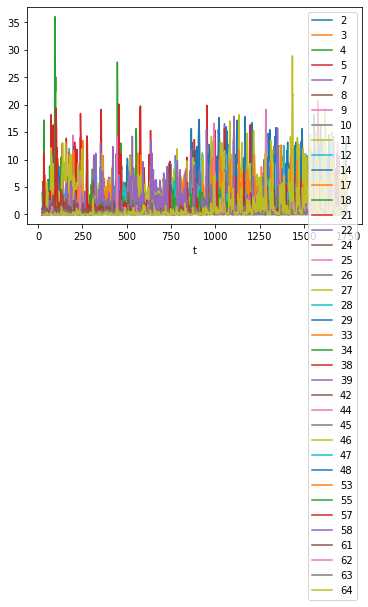

In [74]:
active_EWM_df = active_unit_specific_time_binned_spike_rates_df.copy()
active_EWM_df[data_values_column_names] = active_plot_df[data_values_column_names].ewm(span=4, adjust=False).mean() # 1717 rows × 39 columns

# active_EWM_df = active_plot_df.ewm(span=4, adjust=False).mean() # 1717 rows × 39 columns
# active_EWM_df['t'] = active_plot_df['t'] # replace the time column with the one from the old dataframe, since averaged times don't make sense.
active_EWM_df.plot(x='t')

In [ ]:
active_t = curr_computations_results.computed_data['firing_rate_trends']['active_rolling_window_times'] # dtype='timedelta64[ns]', name='time_delta_sec', length=1717, freq='S')

active_rolling_window_duration = curr_computations_results.computed_data['firing_rate_trends']['desired_window_length_bins']

# curr_computations_results.computed_data['firing_rate_trends']['moving_mean_firing_rates_df'] # 1239 rows × 39 columns
active_df = curr_computations_results.computed_data['firing_rate_trends']['moving_mean_firing_rates_df'].copy()



selected_rows = active_df[~active_df[0].isnull()] # 640 rows × 39 columns
selected_rows

active_rolling_window_duration # 600

# curr_computations_results.computed_data['firing_rate_trends']['moving_mean_firing_rates_df']: is computed using: moving_mean_firing_rates_df = active_firing_rates_df.rolling(window=desired_window_length_bins).mean()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from pyphoplacecellanalysis.General.Model.RenderDataseries import RenderDataseries
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves3D.Render3DTimeCurvesMixin import CurveDatasource
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves3D.Specific3DTimeCurves import Specific3DTimeCurvesHelper

## Adds the binned_spike_counts curves:
active_curve_plotter_3d = spike_raster_plt_3d ## PyQtGraph Mode
# active_curve_plotter_3d = spike_raster_plt_3d_vedo ## Vedo Mode
binned_spike_counts_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_counts_curves(curr_computations_results, active_curve_plotter_3d)


## Unit Time Binned Spike Counts Datasource:

In [77]:
from sklearn.preprocessing import MinMaxScaler
from pyphoplacecellanalysis.General.Model.RenderDataseries import RenderDataseries
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves3D.Render3DTimeCurvesMixin import CurveDatasource
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves3D.Specific3DTimeCurves import Specific3DTimeCurvesHelper

## Adds the binned_spike_counts curves:
active_curve_plotter_3d = spike_raster_plt_3d ## PyQtGraph Mode
# active_curve_plotter_3d = spike_raster_plt_3d_vedo ## Vedo Mode

In [ ]:
## Spike Count (old):
binned_spike_counts_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_counts_curves(curr_computations_results, active_curve_plotter_3d)

In [79]:
## Spike Count:
binned_spike_counts_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='count')

connected_signal_recievers: 1
disconnecting 1 receivers...
	done


In [ ]:
## Spike Rate:
binned_spike_rate_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='rate')

In [78]:
## Spike Smoothed Moving Average Rate:
binned_spike_moving_average_rate_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='mov_average')

In [ ]:
active_curve_plotter_3d.detach_3d_time_curves_datasource()

In [ ]:
spike_raster_plt_3d.cell_id_to_unit_id_map[2]

In [ ]:
binned_spike_counts_curve_datasource.data_series_specs.keys()

In [ ]:
binned_spike_counts_curve_datasource.data_series_specs.data_series_pre_spatial_list

In [ ]:
# valid_data_values_column_names = binned_spike_counts_curve_datasource.df.columns[1:]

# binned_spike_counts_curve_datasource.data_column_names

# binned_spike_counts_curve_datasource.data_column_values
# binned_spike_counts_curve_datasource.df[[1:]]

binned_spike_counts_curve_datasource.df[[1:]]

In [ ]:
# binned_spike_counts_curve_datasource.df.loc[:, binned_spike_counts_curve_datasource.df.columns != 't'] # get all but the 't' column

# np.max(binned_spike_counts_curve_datasource.df.loc[:, binned_spike_counts_curve_datasource.df.columns != 't'])
print(f"min: {np.min(binned_spike_counts_curve_datasource.df.loc[:, binned_spike_counts_curve_datasource.df.columns != 't'])}, max: {np.max(binned_spike_counts_curve_datasource.df.loc[:, binned_spike_counts_curve_datasource.df.columns != 't'])}")

In [ ]:
data_values_column_names = binned_spike_counts_curve_datasource.df.columns[1:] # all but the 't' column
z_scaler = MinMaxScaler()
# active_plot_df[data_values_column_names] = z_scaler.fit_transform(active_plot_df[data_values_column_names].to_numpy()) # scale all data_values_columns (but not the time column)
binned_spike_counts_curve_datasource.df.loc[:, binned_spike_counts_curve_datasource.df.columns != 't'] = z_scaler.fit_transform(binned_spike_counts_curve_datasource.df.loc[:, binned_spike_counts_curve_datasource.df.columns != 't']) # scale all data_values_columns (but not the time column)
binned_spike_counts_curve_datasource.df.loc[:, binned_spike_counts_curve_datasource.df.columns != 't']

In [ ]:
test_unit_time_binned_spike_counts_df = pd.DataFrame(np.concatenate((np.atleast_2d(curr_computations_results.computed_data['pf2D_Decoder'].time_window_centers), curr_computations_results.computed_data['pf2D_Decoder'].unit_specific_time_binned_spike_counts)).T)
test_unit_time_binned_spike_counts_df.columns = ['t'] + [str(an_id) for an_id in included_neuron_ids]
# curr_computations_results.computed_data['pf2D_Decoder'].time_window_centers
# curr_computations_results.computed_data['pf2D_Decoder'].unit_specific_time_binned_spike_counts
# test_unit_time_binned_spike_counts_df

In [ ]:


# Add the datasource to the actual plotter object: this will cause it to build and add the 3D time curves:

active_curve_plotter_3d = spike_raster_plt_3d ## PyQtGraph Mode
# active_curve_plotter_3d = spike_raster_plt_3d_vedo ## Vedo Mode

active_plot_df = test_unit_time_binned_spike_counts_df.copy()
valid_data_values_column_names = active_plot_df.columns[1:]

# Mappings from the pre-spatial values to the spatial values:
x_map_fn = lambda t: active_curve_plotter_3d.temporal_to_spatial(t) # returns the x-values, transforming from the times t appropriately.
# y_map_fn = lambda v: np.full_like(v, -active_curve_plotter_3d.n_half_cells) # This is what places all values along the back wall
z_map_fn = lambda v_main: v_main + active_curve_plotter_3d.floor_z # returns the un-transformed primary value

## we want each test curve to be rendered with a unit_id (series of spikes), so we'll need custom y_map_fn's for each column
num_t_points = np.shape(active_plot_df)[0]
n_value_columns = np.shape(active_plot_df)[1] - 1 # get the total num columns, then subtract 1 to account for the 0th ('t') column

## want a separate y_map_fn for each data series so it returns the correct index
# lambda v: np.full_like(v, -active_curve_plotter_3d.n_half_cells)
# data_series_pre_spatial_to_spatial_mappings = [{'name':'name','x':'t','y':'v_alt','z':'v_main','x_map_fn':x_map_fn,'y_map_fn':y_map_fn,'z_map_fn':z_map_fn} for i in np.arange(1, n_value_columns)]
# data_series_pre_spatial_to_spatial_mappings = [{'name':'name','x':'t','y':'v_alt','z':'v_main','x_map_fn':x_map_fn,'y_map_fn':(lambda v, bound_i=i: np.full_like(v, bound_i)),'z_map_fn':z_map_fn} for i in np.arange(n_value_columns)]
data_series_pre_spatial_to_spatial_mappings = [{'name':'name','x':'t','y':'v_alt','z':'v_main','x_map_fn':x_map_fn,'y_map_fn':(lambda v, bound_i=i: np.full_like(v, active_curve_plotter_3d.unit_id_to_spatial(bound_i))),'z_map_fn':z_map_fn} for i in np.arange(n_value_columns)]
active_data_series_pre_spatial_list = [{'name':data_col_name,'t':'t','v_alt':None,'v_main':data_col_name,'color_name':'white', 'line_width': 1.0, 'z_scaling_factor':1.0}                                              
                                               for data_col_name in list(valid_data_values_column_names)]

binned_spike_counts_curve_datasource = CurveDatasource(active_plot_df.copy(), data_series_specs=RenderDataseries.init_from_pre_spatial_data_series_list(active_data_series_pre_spatial_list, data_series_pre_spatial_to_spatial_mappings))

active_curve_plotter_3d.add_3D_time_curves(curve_datasource=binned_spike_counts_curve_datasource) # Add the curves from the datasource

## TODO: only if vedo should we do this! It's required to prevent it from crashing on window update:
# spike_raster_plt_3d_vedo.params.time_curves_no_update = True

## Other Series Testing:

In [ ]:
np.shape(curr_computations_results.computed_data['pf2D_Decoder'].time_window_centers) # (1717,)
np.shape(curr_computations_results.computed_data['pf2D_Decoder'].time_window_edges) # (1718,)
# curr_computations_results.computed_data['pf2D_Decoder'].time_window_center_binning_info # BinningInfo object, 1717 bins
np.shape(curr_computations_results.computed_data['pf2D_Decoder'].F) # (1239, 39)
# total_spike_counts_per_window: note this seems to be the total across all units (for each time bin):
np.shape(curr_computations_results.computed_data['pf2D_Decoder'].total_spike_counts_per_window) # (1717,)
# unit_specific_time_binned_spike_counts: this is the number of spikes per window still separated by unit! Yay!
np.shape(curr_computations_results.computed_data['pf2D_Decoder'].unit_specific_time_binned_spike_counts) # (39, 1717)
curr_computations_results.computed_data['pf2D_Decoder'].unit_specific_time_binned_spike_counts

In [ ]:
# Build the data series to display:
curr_computations_results.computed_data['firing_rate_trends']['mean_firing_rates'][0]

In [ ]:
# Get the computed most-likely positions and timesteps from the pf2D_TwoStepDecoder:
active_two_step_decoder = curr_computations_results.computed_data.get('pf2D_TwoStepDecoder', None)
if active_two_step_decoder is not None:
    # have valid two_step_decoder, plot those predictions as well:
    # active_two_step_decoder['most_likely_positions'][:, time_window_bin_idx]
    active_time_window_variable = curr_computations_results.computed_data['pf2D_Decoder'].active_time_window_centers
    active_most_likely_positions_x = active_two_step_decoder['most_likely_positions'][0,:]
    active_most_likely_positions_y = active_two_step_decoder['most_likely_positions'][1,:]
else:
    active_time_window_variable = None
    active_most_likely_positions_x = None
    active_most_likely_positions_y = None

In [ ]:
np.shape(active_time_window_variable) # (1717,)
np.shape(active_most_likely_positions_x) # (1717,)

In [ ]:
active_two_step_decoder.keys()

In [ ]:
np.shape(curr_computations_results.computed_data['firing_rate_trends']['mean_firing_rates']) # (39,). Note that there is one value for each unit here (over all time)

In [ ]:
curr_computations_results.computed_data['firing_rate_trends'].keys() # dict_keys(['active_rolling_window_times', 'mean_firing_rates', 'desired_window_length_seconds', 'desired_window_length_bins', 'active_firing_rates_df', 'moving_mean_firing_rates_df'])

# good_only_moving_mean_firing_rates_df = moving_mean_firing_rates_df.dropna() # 3910 rows x 43 columns

np.shape(curr_computations_results.computed_data['firing_rate_trends']['active_rolling_window_times']) # (1717,)
# np.shape(curr_computations_results.computed_data['firing_rate_trends']['moving_mean_firing_rates_df']) # (1239, 39)
np.shape(curr_computations_results.computed_data['firing_rate_trends']['active_firing_rates_df']) # (1239, 39)
curr_computations_results.computed_data['firing_rate_trends']['active_firing_rates_df']

In [ ]:
np.shape(curr_computations_results.computed_data['pf2D_Decoder'].F) # (1239, 39)

curr_computations_results.computed_data['pf2D_Decoder']

In [ ]:

# spike_raster_plt_3d.dynamic_add_widget(widget=spike_raster_plt_2d)

# spike_raster_plt_3d.ui.layout.addChildLayout
# spike_raster_plt_3d.ui.layout.addWidget(spike_raster_plt_2d, 1, 0) # add the GLViewWidget to the layout at 0, 0
spike_raster_plt_3d.ui.layout.addWidget(spike_raster_plt_2d, 2, 0) # row 2, column 0


# spike_raster_plt_2d.setParent(spike_raster_plt_3d)

# class MainWindow(QMainWindow):
#     def __init__(self):
#         super().__init__()
#         self.w = AnotherWindow()
#         self.button = QPushButton("Push for Window")
#         self.button.clicked.connect(self.toggle_window)
#         self.setCentralWidget(self.button)

#     def toggle_window(self, checked):
#         if self.w.isVisible():
#             self.w.hide()

#         else:
#             self.w.show()


## Other Sorting/Etc:

In [ ]:
firing_rate_cell_index_sort = np.argsort(curr_computations_results.computed_data['firing_rate_trends']['mean_firing_rates']) 
firing_rate_cell_index_sort.shape # (39,)

In [ ]:
# spike_raster_plt_3d.n_cells # 40
spike_raster_plt_3d.cell_ids # (40,)
np.setdiff1d(spike_raster_plt_3d.cell_ids, curr_neuron_IDs) # array([23])


In [ ]:
spike_raster_plt_3d.unit_sort_order = firing_rate_cell_index_sort # AssertionError: len(self._unit_sort_order): 40 must equal self.n_cells: 40 but it does not!

In [ ]:
from pyphoplacecellanalysis.General.Model.Datasources import DataframeDatasource, SpikesDataframeDatasource
from pyphoplacecellanalysis.General.Model.TimeWindow import TimeWindow
from pyphoplacecellanalysis.General.Model.LiveWindowedData import LiveWindowedData

position_dataSource = DataframeDatasource(curr_sess.position.to_dataframe()) # [['t', 'x','y','lin_pos']] # build new dataframe with only relevant columns
spikes_dataSource = SpikesDataframeDatasource(curr_spikes_df)
curr_time_window = TimeWindow(window_duration=15.0, window_start_time=30.0)
spikes_liveWinData = LiveWindowedData(curr_time_window, spikes_dataSource)

In [ ]:
spikes_dataSource.custom_datasource_name
# spikes_dataSource.datasource_UIDs
# spikes_dataSource.time_column_name # 't_rel_seconds'
spikes_dataSource.data_column_names # array(['PBE_id', 'aclu', 'cell_type', 'cluster', 'flat_spike_idx', 'lap', 'lin_pos', 'maze_id', 'maze_relative_lap', 'qclu', 'scISI', 'shank', 'speed', 't', 't_seconds', 'traj', 'unit_id', 'x', 'x_loaded', 'y', 'y_loaded'], dtype=object)

In [ ]:
curr_sess.mua.t_start # 22.26
curr_sess.mua.t_stop # 1739.153

# curr_sess.mua.time
# np.shape(curr_sess.mua.firing_rate) # (1716893,)
# np.shape(curr_sess.mua.spike_counts) # (1716893,)

smoothed_mua = curr_sess.mua.get_smoothed()
smoothed_mua.to_dataframe()

In [ ]:
curr_windowed_df = position_dataSource.get_updated_data_window(0.0, 100.0)

In [ ]:
""" Cell Coloring:
    curr_color = pg.mkColor((i, self.n_cells*1.3))
    curr_color.setAlphaF(0.5)

"""
def build_cell_color_map(unit_ids, mode='color_by_index_order'):
    """ builds a list of pg.mkColors from the cell index id: 
    """
    n_cells = len(unit_ids)
    if mode == 'preserve_unit_ids':
        # color is assigned based off of unit_id value, meaning after re-sorting the unit_ids the colors will appear visually different along y but will correspond to the same units as before the sort.
        unit_ids_sort_index = np.argsort(unit_ids) # get the indicies of the sorted ids
        sorted_unit_ids = np.sort(unit_ids)
        sorted_unit_ids = np.take_along_axis(unit_ids, unit_ids_sort_index, axis=None)
        print(f'unit_ids: \t\t{unit_ids}\nunit_ids_sort_index: \t{unit_ids_sort_index}\nsorted_unit_ids: \t{sorted_unit_ids}\n')
        return [pg.mkColor((cell_id, n_cells*1.3)) for i, cell_id in enumerate(sorted_unit_ids)]
    elif mode == 'color_by_index_order':
        # color is assigned based of the raw index order of the passed-in unit ids. This means after re-sorting the units the colors will appear visually the same along y, but will not correspond to the same units.
        return [pg.mkColor((i, n_cells*1.3)) for i, cell_id in enumerate(unit_ids)]
    else:
        raise NotImplementedError
    # for i, cell_id in enumerate(self.unit_ids):
    #         curr_color = pg.mkColor((i, self.n_cells*1.3))
    #         curr_color.setAlphaF(0.5)



# build_cell_color_map(spike_raster_plt_3d.unit_ids, mode='color_by_index_order')
build_cell_color_map(spike_raster_plt_3d.unit_ids, mode='preserve_unit_ids')

In [ ]:
""" 
Ordering of cells is dictated by self.unit_ids' order

Changing this order requires changing several pieces of information:


- the y-axis numerical labels
    _build_neuron_id_graphics(...)
    _update_neuron_id_graphics()


"""
## Testing changing the cell-sort along the y-axis:
spike_raster_plt_3d.y = DataSeriesToSpatial.build_series_identity_axis(spike_raster_plt_3d.n_cells, center_mode=spike_raster_plt_3d.params.center_mode, bin_position_mode=spike_raster_plt_3d.params.bin_position_mode, side_bin_margins = spike_raster_plt_3d.params.side_bin_margins)

## Debugging Rendering:

In [ ]:
# -self.n_half_cells
debug_point_pos = (-spike_raster_plt_3d.half_temporal_axis_length, -spike_raster_plt_3d.n_half_cells, 0.0) # (-10.69215668859044, -20.0, 0.0)
debug_point_pos

In [ ]:
spike_raster_plt_3d.ui.gl_test_points = []
md = gl.MeshData.sphere(rows=4, cols=4)
m1 = gl.GLMeshItem(meshdata=md, smooth=False, drawFaces=False, drawEdges=True, edgeColor=(0.7,0.7,0.7,0.8))
m1.translate(debug_point_pos[0], debug_point_pos[1], debug_point_pos[2])
m1.scale(0.5, 0.25, 0.25)
m1.setGLOptions('additive')
spike_raster_plt_3d.ui.main_gl_widget.addItem(m1)
spike_raster_plt_3d.ui.gl_test_points.append(m1)


# spike_raster_plt_3d.dynamic_add_widget()

In [ ]:
# REMOVE

spike_raster_plt_3d.ui.main_gl_widget.removeItem(m1)
spike_raster_plt_3d.ui.gl_test_points.remove(m1)

In [ ]:
spike_raster_plt_3d.add_render_epochs(curr_sess.pbe.starts, curr_sess.pbe.durations, epoch_type_name='PBE')

In [ ]:
spike_raster_plt_3d._build_epoch_meshes(curr_sess.pbe.starts, curr_sess.pbe.durations)

# spike_raster_plt_3d.ui.parent_epoch_container_item.setObjectName('container')
# spike_raster_plt_3d.ui.parent_epoch_container_item.childItems()
# curr_cube.translate(t_centers[i], 0, 0)
# curr_cube.scale(durations[i], 1, 0.25)
    

In [ ]:
spike_raster_plt_3d._remove_epoch_meshes()

In [ ]:
# for (i, aCube) in enumerate(spike_raster_plt_3d.ui.new_cube_objects):
#     aCube.setParent(None)
#     aCube.deleteLater()

from vispy import geometry

# spike_raster_plt_3d.ui.new_cube_objects.clear()
# spike_raster_plt_3d.ui.new_cube_objects
print(f'number of cube objects: {len(spike_raster_plt_3d.ui.new_cube_objects)}') # number of cube objects: 206

spike_raster_plt_3d._temporal_to_spatial(curr_sess.pbe.starts)

# vispy.geometry.create_box(width=1, height=1, depth=1, width_segments=1, height_segments=1, depth_segments=1, planes=None)
box_mesh_data = geometry.create_box(width=1, height=1, depth=1, width_segments=1, height_segments=1, depth_segments=1, planes=None)
# vispy.geometry.create_plane(width=1, height=1, width_segments=1, height_segments=1, direction='+z')
plane_mesh_data = geometry.create_plane(width=1, height=1, width_segments=1, height_segments=1, direction='+z')
# vertices, faces, outline

plane_mesh_data

In [ ]:
spike_raster_plt_3d.update_epoch_meshes(curr_sess.pbe.starts, curr_sess.pbe.durations)

In [ ]:
spike_raster_plt_2d.render_window_duration # 15.0
spike_raster_plt_2d.spikes_window.total_df_start_end_times # (22.30206346133491, 1739.1355703625595)
spike_raster_plt_2d.spikes_window.active_window_start_time # 30.0
spike_raster_plt_2d.spikes_window.active_window_end_time # 45.0

In [ ]:
spike_raster_plt_3d.close_signal.connect(spike_raster_plt_2d.closeEvent)

### Align 3d window and the 2d window that controls it

In [ ]:
# spike_raster_plt.ui.main_plot_widget.setXRange(0.0, +spike_raster_plt.render_window_duration)

# spike_raster_plt.ui.scatter_plot.enableAutoRange('xy', False)  ## stop auto-scaling after the first data set is plotted
# spike_raster_plt.ui.scatter_plot.dataBounds()
# spike_raster_plt.ui.scatter_plot.flags()
# spike_raster_plt.ui.scatter_plot.setPointsVisible
# spike_raster_plt.ui.main_plot_widget.addScrollBarWidget()

# print(f'{spike_raster_plt.ui.main_plot_widget.contentsMargins()}')
# spike_raster_plt.ui.scatter_plot.points()

# spike_raster_plt.ui.main_plot_widget.setXRange
# spike_raster_plt.ui.main_plot_widget.setLimits()
# spike_raster_plt.ui.main_plot_widget # PlotItem

min_x, max_x = spike_raster_plt_2d.ui.scroll_window_region.getRegion() # (59.62061245756003, 76.83228787177144)
scroll_window_width = max_x - min_x
spike_raster_plt_2d_old_time_window = spike_raster_plt_2d.spikes_window.active_time_window # (30.0, 930.0)
print(f'spike_raster_plt_2d: min_x: {min_x}, max_x: {max_x}, scroll_window_width: {scroll_window_width}, spike_raster_plt_2d_old_time_window: {spike_raster_plt_2d_old_time_window}') # spike_raster_plt_2d: min_x: 111.72696109457753, max_x: 149.92210657285403, scroll_window_width: 38.1951454782765, spike_raster_plt_2d_old_time_window: (111.72696109457753, 149.92210657285403)

# def _debug_print_spike_raster_plot_window(
spike_raster_plt_3d_old_time_window = spike_raster_plt_3d.spikes_window.active_time_window # (30.0, 930.0)
print(f'spike_raster_plt_3d: spike_raster_plt_3d_old_time_window: {spike_raster_plt_3d_old_time_window}') # spike_raster_plt_3d: spike_raster_plt_3d_old_time_window: (47.599999999999625, 62.599999999999625)

# Update the 3D Time window from the 2D one:
# spike_raster_plt_3d.spikes_window.active_time_window = spike_raster_plt_2d_old_time_window
spike_raster_plt_3d.spikes_window.update_window_start_end(spike_raster_plt_2d_old_time_window[0], spike_raster_plt_2d_old_time_window[1])

# spike_raster_plt.render_window_duration = 
# spike_raster_plt.spikes_window
# spike_raster_plt.temporal_zoom_factor
# # self.spikes_window.update_window_start(next_start_timestamp)

# spike_raster_plt.ui.spinTemporalZoomFactor.setValue(1.0)
# spike_raster_plt.ui.spinRenderWindowDuration.setValue(scroll_window_width)
# spike_raster_plt.spikes_window.update_window_start(min_x)

# curr_plot_item = spike_raster_plt.ui.main_plot_widget.getPlotItem()
# curr_view_box = curr_plot_item.getViewBox()
# # curr_view_box.autoRangeEnabled()
# # curr_view_box.setAutoPan(False)

# curr_view_box.setDefaultPadding(0.0)
# spike_raster_plt.ui.main_plot_widget.viewRect()
# spike_raster_plt.ui.scatter_plot.opts
# spike_raster_plt._update_plot_ranges()

In [ ]:
# @pyqtSlot(float, float)
def _test_on_2d_window_scrolled(start_v, end_v):
    print(f'_test_on_2d_window_scrolled(start_v: {start_v}, end_v: {end_v})')
    spike_raster_plt_3d.spikes_window.update_window_start_end(start_v, end_v)

spike_raster_plt_2d.window_scrolled.connect(_test_on_2d_window_scrolled)

In [ ]:
spike_raster_plt_3d.ui.spinRenderWindowDuration.setValue(scroll_window_width)

In [ ]:
spike_raster_plt_3d.ui.spinTemporalZoomFactor.setValue(10.0)

In [ ]:
spike_raster_plt_3d.update()

In [ ]:
lower_edge = spike_raster_plt.y / spike_raster_plt.n_cells
upper_edge = (spike_raster_plt.y + 1.0)/spike_raster_plt.n_cells

print(f'lower_edge: {lower_edge}\n upper_edge: {upper_edge}')

In [ ]:
lower_y = DataSeriesToSpatial.build_series_identity_axis(spike_raster_plt.n_cells, center_mode=spike_raster_plt.params.center_mode, bin_position_mode='left_edges', side_bin_margins = spike_raster_plt.params.side_bin_margins) / spike_raster_plt.n_cells
upper_y = DataSeriesToSpatial.build_series_identity_axis(spike_raster_plt.n_cells, center_mode=spike_raster_plt.params.center_mode, bin_position_mode='right_edges', side_bin_margins = spike_raster_plt.params.side_bin_margins) / spike_raster_plt.n_cells

print(f'lower_y: {lower_y}\n upper_y: {upper_y}')

In [ ]:
## 3D Spike Train Visualization
# import pyqtgraph.opengl as gl # for 3D raster plot
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster

# importlib.reload(pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_RasterPlot)

curr_epoch_name = 'maze1'
curr_epoch = curr_active_pipeline.filtered_epochs[curr_epoch_name] # <NamedTimerange: {'name': 'maze1', 'start_end_times': array([  22.26      , 1739.15336412])};>
curr_sess = curr_active_pipeline.filtered_sessions[curr_epoch_name]
curr_spikes_df = curr_sess.spikes_df

spike_raster_plt = Spike3DRaster(curr_spikes_df, window_duration=1.0, window_start_time=30.0, neuron_colors=None)
# spike_raster_plt = Spike3DRaster(curr_spikes_df, window_duration=4.0, window_start_time=30.0, neuron_colors=None)
# spike_raster_plt = Spike3DRaster(curr_spikes_df, window_duration=0.2, window_start_time=30.0)

# spike_raster_plt.animation()
# spike_raster_plt = None

In [ ]:
print(f'spike_raster_plt.spikes_window.active_time_window: {spike_raster_plt.spikes_window.active_time_window}')
# spike_raster_plt.spikes_window.active_window_start_time = 50.0
spike_raster_plt.spikes_window.update_window_start(90.0)
print(f'spike_raster_plt.spikes_window.active_time_window: {spike_raster_plt.spikes_window.active_time_window}')

In [ ]:
spike_raster_plt.animation_time_step # 0.03 (seconds)

In [ ]:
# spike_raster_plt.render_window_duration # 4.0 (seconds)
# spike_raster_plt.spikes_window.window_duration = 1.0

spike_raster_plt.temporal_zoom_factor # 40.0
spike_raster_plt.temporal_zoom_factor = 80.0

In [ ]:
spike_raster_plt.on_adjust_temporal_spatial_mapping()

In [ ]:
# curr_transform = spike_raster_plt.ui.gz.transform() # PyQt5.QtGui.QMatrix4x4(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -10.0, 0.0, 0.0, 0.0, 1.0)
curr_transform = spike_raster_plt.ui.gx.transform() # PyQt5.QtGui.QMatrix4x4(0.0, 0.0, 1.0, -20.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)
print(curr_transform)

curr_transform.matrix()
# spike_raster_plt.ui.gx.

In [ ]:
spike_raster_plt.params.keys()

In [ ]:
# spike_raster_plt.params.spike_start_z # -10
spike_raster_plt.params.spike_end_z = -8.0 # -6.0

In [ ]:
spike_raster_plt.animation_time_step = 0.06

In [ ]:
spike_raster_plt.shift_animation_frame_val(-3)

In [ ]:
curr_spikes_df

In [ ]:
# temporal_to_spatial_transform_computation
np.shape(curr_sess.mua.firing_rate) # (1716893,)
np.shape(curr_sess.mua.time) # (1716893,)

yi = - # plot along the back wall in the y-dir
mua_pts = np.column_stack([x, np.full_like(x, yi), z])
plt = gl.GLLinePlotItem(pos=pts, color=pg.mkColor((i,n*1.3)), width=(i+1)/10., antialias=True)
w.addItem(plt)


    
